In [16]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [17]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [18]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [19]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=256)

fashion


In [20]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

### VAE

In [21]:
model_name = "vae128"
z_size = 128

vae = models.SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=500)
vae.load_state_dict(torch.load("../cache/models/VAE_Fashion/FC-VAE128Fashion_3.sd"));

Version 4


In [22]:
# Latent z optimization

def genopt(sample_magn, vae, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    vae.to(device)
    vae.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        z = torch.randn((sample_magn.shape[0], z_size), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x).clone().detach().requires_grad_(True)
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = vae.decoder(z)
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)
            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = vae.decoder(z)

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [80]:
### Latent z optimization ###

num_batches = 4
batch_size = 256
steps = 1
lmd = 0.0
lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results_total = np.zeros((batch_size * num_batches, restarts, *imsize))
errors = np.full((batch_size * num_batches, restarts, steps), np.inf)

with tqdm(total=restarts*num_batches) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        
        for rix in range(restarts):
            cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, vae=vae, device=device,
                                                          steps=steps, lmd=lmd, lr=lr)

            out_results_total[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = cur_out_results
            errors[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = np.array(cur_error).T

            pbar.update()
        if batch_i + 1 >= num_batches:
            break
            
best_ix = np.argmin(errors[..., -1], axis=-1)
out_results = np.array([out_results_total[i, ix] for i, ix in enumerate(best_ix)])

In [81]:
### CACHE ERRORS ###

import pickle
pickle.dump(errors, open("../cache/dpr/Fashion_err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [82]:
### LOAD ERRORS ###
import pickle

errors = pickle.load(open("../cache/dpr/Fashion_err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

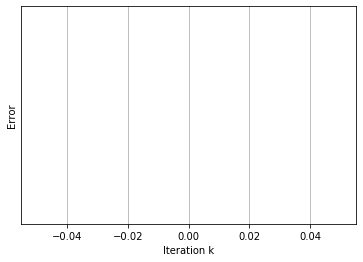

In [83]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=(0, 1)))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/dpr/Fashion_DPR_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

In [84]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("../cache/dpr/Fashion_dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "wb"))
pickle.dump(out_results, open("../cache/dpr/Fashion_dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [85]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("../cache/dpr/Fashion_dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "rb"))
out_results = pickle.load(open("../cache/dpr/Fashion_dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


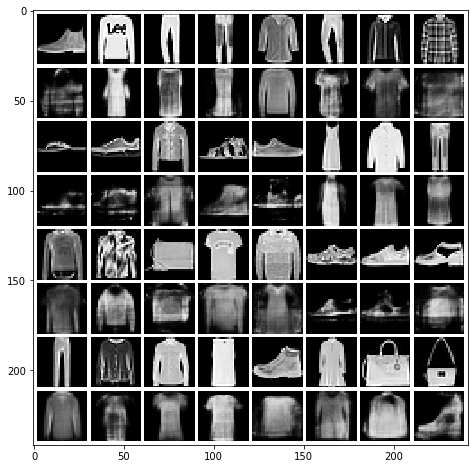

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


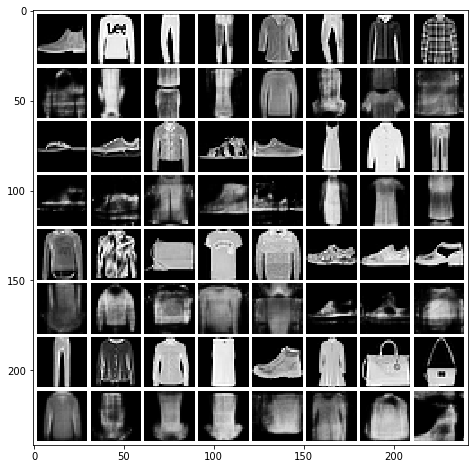

In [86]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/Fashion/generative-prior/dpr-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/generative-prior/dpr-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [87]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.10450744635817136, std: 0.05687077386504159
  MAE: 0.20721538779556495, std: 0.07399140136975473
  SSIM: 0.22047647458221042, std: 0.14924963462329988
  Sharpness: 0.17593095380968893, std: 0.03894764718608776
  PhCo-MSE: 0.12141431913362334, std: 0.07870055157171134
  PhCo-MAE: 0.23154944907834918, std: 0.1014414895166661
  PhCo-SSIM: 0.22502167439406134, std: 0.15544749419214113
  CroCo-MSE: 0.08373211892663321, std: 0.05066188535431766
  CroCo-MAE: 0.18118206999675124, std: 0.06784319442504402
  CroCo-SSIM: 0.32195935286332356, std: 0.12721728991889833

Magnitude error:
  MSE Magnitude: 36.89330789887778, std: 30.424579841799073

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.1045 | 0.2072 | 0.2205 | 0.1759 | 0.1214 | 0.2315 | 0.2250 | 0.08373 | 0.1812 | 0.3220 | 36.89 |


### dim(z) = 128

Signal error:
  MSE: 0.061285576149657295, std: 0.053183383058570274
  MAE: 0.12838272303485943, std: 0.07545499855273291
  SSIM: 0.4762667920198273, std: 0.28555523890921974
  Sharpness: 0.14287983354474132, std: 0.06999751928280129
  PhCo-MSE: 0.04630413787596191, std: 0.06133944945567254
  PhCo-MAE: 0.1100058315891995, std: 0.08847470351521595
  PhCo-SSIM: 0.5882191536807535, std: 0.2776433240515045
  CroCo-MSE: 0.028693739801263628, std: 0.0263290570261469
  CroCo-MAE: 0.08670936377818803, std: 0.05042381118691865
  CroCo-SSIM: 0.654126566915679, std: 0.21324060621269603

Magnitude error:
  MSE Magnitude: 1.6068002569654283, std: 1.328270699371165

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.1 | - | 0.1045 | 0.2072 | 0.2205 | 0.1759 | 0.1214 | 0.2315 | 0.2250 | 0.08373 | 0.1812 | 0.3220 | 36.89 |
| 10 | 0.1 | - | 0.08590 | 0.1699 | 0.3182 | 0.1730 | 0.09648 | 0.1854 | 0.3364 | 0.05725 | 0.1351 | 0.4468 | 14.93 |
| 25 | 0.1 | - | 0.07759 | 0.1535 | 0.3792 | 0.1639 | 0.07906 | 0.1574 | 0.4194 | 0.04506 | 0.1139 | 0.5302 | 8.477 |
| 100 | 0.1 | - | 0.06789 | 0.1389 | 0.4350 | 0.1496 | 0.05839 | 0.1279 | 0.5199 | 0.03382 | 0.09618 | 0.6032 | 3.859 |
| 500 | 0.1 | - | 0.06180 | 0.1296 | 0.4733 | 0.1422 | 0.05201 | 0.1183 | 0.5639 | 0.02970 | 0.08888 | 0.6387 | 2.352 |
| 1000 | 0.1 | - | 0.06327 | 0.1307 | 0.4686 | 0.1406 | 0.04494 | 0.1089 | 0.5862 | 0.02862 | 0.08682 | 0.6507 | 2.011 |
| 2000 | 0.1 | - | 0.06334 | 0.1308 | 0.4722 | 0.1427 | 0.05124 | 0.1159 | 0.5748 | 0.02867 | 0.08697 | 0.6496 | 1.826 |
| 4000 | 0.1 | - | 0.06111 | 0.1275 | 0.4844 | 0.1405 | 0.04605 | 0.1091 | 0.5914 | 0.02769 | 0.08485 | 0.6602 | 1.707 |
| 10000 | 0.1 | - | 0.06129 | 0.1284 | 0.4763 | 0.1429 | 0.04630 | 0.1100 | 0.5882 | 0.02869 | 0.08671 | 0.6541 | 1.607 |